In [3]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

In [4]:
plant_gen = pd.read_csv('../data/Plant_1_Generation_Data.csv')
plant_weat = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')

# Convert DATR_TIME from string to datetime
plant_gen['DATE_TIME'] = pd.to_datetime(plant_gen['DATE_TIME'])
plant_weat['DATE_TIME'] = pd.to_datetime(plant_weat['DATE_TIME'])

In [5]:
plant_gen['dt'] = plant_gen['DATE_TIME']
plant_weat['dt'] = plant_weat['DATE_TIME']
plant_gen = plant_gen.set_index('DATE_TIME')
plant_weat = plant_weat.set_index('DATE_TIME')

In [6]:
def plot_day_ac_mean_std(d1, d2):
    date = plant_gen[d1:d2]
    df = pd.DataFrame(columns=['Datetime', 'MeanAC', 'std'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['AC_POWER'].mean(), gp['AC_POWER'].std()]
        i+=1
    plt.figure(figsize=(20, 10))
    for key in date['SOURCE_KEY'].unique():
        plt.plot(date[date['SOURCE_KEY'] == key].index, date[date['SOURCE_KEY'] == key]['AC_POWER'], 'o', color='black')

    df['Datetime'] = pd.to_datetime(df['Datetime'])
    plt.plot(df['Datetime'], df['MeanAC'], color='red')
    plt.plot(df['Datetime'], df['MeanAC'] + 3 * df['std'], color='blue')
    plt.plot(df['Datetime'], df['MeanAC'] - 3 * df['std'], color='green')
    plt.show()

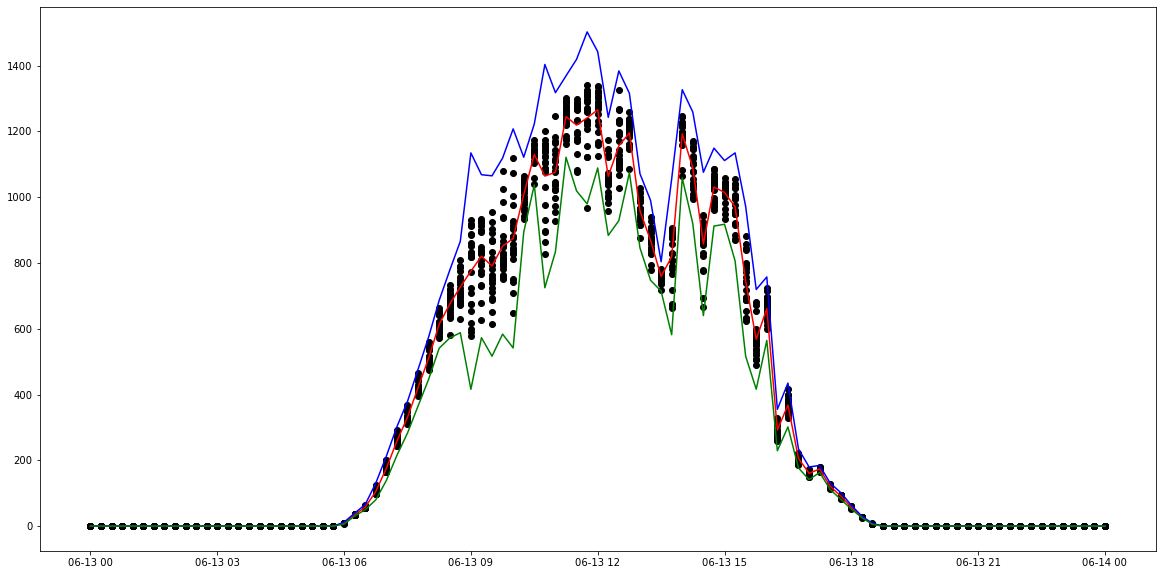

In [7]:
plot_day_ac_mean_std('2020-06-13 00:00:00', '2020-06-14 00:00:00')

In [8]:
def find_outliers_ac(d1, d2, th=3):
    date = plant_gen[d1:d2] # get the data associated to d1:d2
    
    # df is going to b a dataframe which will contain MeanAC, std for each DATE_TIME
    df = pd.DataFrame(columns=['DATE_TIME', 'MeanAC', 'std'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['AC_POWER'].mean(), gp['AC_POWER'].std()]
        i+=1
    # df is ready
    
    # a list to store all outlier inverters
    l = {}
    
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    df.set_index('DATE_TIME', inplace=True)
    
    for key in date['SOURCE_KEY'].unique():
        inv_data = date[date['SOURCE_KEY'] == key]
        for d in inv_data.index:
            MeanAC = df[df.index == d]['MeanAC'][0]
            std = df[df.index == d]['std'][0]
            AC_POWER = inv_data[inv_data.index == d]['AC_POWER'][0]
            
            if AC_POWER > 0 and (MeanAC-th*std>=AC_POWER or MeanAC+th*std<=AC_POWER):
                if key in l:
                    l[key] += 1
                else:
                    l[key] = 1
    return l

In [9]:
out_invs = {}
for dayofyear in plant_gen['dt'].dt.dayofyear.unique():
    d = datetime(2020, 1, 1) + timedelta(int(dayofyear) - 1)
    year = d.year
    month = d.month if d.month > 9 else '0' + str(d.month)
    day = d.day if d.day > 9 else '0' + str(d.day)
    try:
        invs = find_outliers_ac(f'{year}-{month}-{day} 00:00:00', f'{year}-{month}-{day} 23:59:00')
        for k in invs.keys():
            if k in out_invs:
                out_invs[k]+=invs[k]
            else:
                out_invs[k] =invs[k]
        print(f'{year}-{month}-{day}', invs)
    except Exception as e:
        print(f'{year}-{month}-{day} 00:00:00', e)

2020-05-15 {'VHMLBKoKgIrUVDU': 1, 'z9Y9gH1T5YWrNuG': 1, 'YxYtjZvoooNbGkE': 1}
2020-05-16 {}
2020-05-17 {'1BY6WEcLGh8j5v7': 2, 'adLQvlD726eNBSB': 1}
2020-05-18 {'ZnxXDlPa8U1GXgE': 1, 'adLQvlD726eNBSB': 1, 'rGa61gmuvPhdLxV': 1}
2020-05-19 {}
2020-05-20 {'ZnxXDlPa8U1GXgE': 1, 'bvBOhCH3iADSZry': 6}
2020-05-21 {}
2020-05-22 {'McdE0feGgRqW7Ca': 1, 'rGa61gmuvPhdLxV': 10}
2020-05-23 {'1BY6WEcLGh8j5v7': 1, 'rGa61gmuvPhdLxV': 6, 'uHbuxQJl8lW7ozc': 1}
2020-05-24 {'uHbuxQJl8lW7ozc': 1, 'zBIq5rxdHJRwDNY': 1}
2020-05-25 {'ZnxXDlPa8U1GXgE': 1, 'ih0vzX44oOqAx2f': 2}
2020-05-26 {}
2020-05-27 {}
2020-05-28 {'1BY6WEcLGh8j5v7': 1}
2020-05-29 {}
2020-05-30 {'bvBOhCH3iADSZry': 4}
2020-05-31 {'adLQvlD726eNBSB': 1, 'bvBOhCH3iADSZry': 3}
2020-06-01 {'bvBOhCH3iADSZry': 1}
2020-06-02 {'bvBOhCH3iADSZry': 2}
2020-06-03 {'bvBOhCH3iADSZry': 1}
2020-06-04 {}
2020-06-05 {'uHbuxQJl8lW7ozc': 1}
2020-06-06 {}
2020-06-07 {'uHbuxQJl8lW7ozc': 1}
2020-06-08 {'1BY6WEcLGh8j5v7': 1}
2020-06-09 {'1BY6WEcLGh8j5v7': 1}
2020-06-10 

In [10]:
out_invs

{'VHMLBKoKgIrUVDU': 1,
 'z9Y9gH1T5YWrNuG': 1,
 'YxYtjZvoooNbGkE': 1,
 '1BY6WEcLGh8j5v7': 8,
 'adLQvlD726eNBSB': 5,
 'ZnxXDlPa8U1GXgE': 3,
 'rGa61gmuvPhdLxV': 17,
 'bvBOhCH3iADSZry': 29,
 'McdE0feGgRqW7Ca': 1,
 'uHbuxQJl8lW7ozc': 4,
 'zBIq5rxdHJRwDNY': 2,
 'ih0vzX44oOqAx2f': 2,
 '3PZuoBAID5Wc2HD': 1,
 'WRmjgnKYAwPKWDb': 1}

In [11]:
def plot_day_dc_mean_std(d1, d2):
    date = plant_gen[d1:d2]
    df = pd.DataFrame(columns=['Datetime', 'MeanDC', 'std'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['DC_POWER'].mean(), gp['DC_POWER'].std()]
        i+=1
    plt.figure(figsize=(20, 10))
    for key in date['SOURCE_KEY'].unique():
        plt.plot(date[date['SOURCE_KEY'] == key].index, date[date['SOURCE_KEY'] == key]['DC_POWER'], 'o', color='black')

    df['Datetime'] = pd.to_datetime(df['Datetime'])
    #plt.plot(df['Datetime'], df['MeanDC'], color='red')
    #plt.plot(df['Datetime'], df['MeanDC'] + 3 * df['std'], color='blue')
    #plt.plot(df['Datetime'], df['MeanDC'] - 3 * df['std'], color='green')
    plt.show()

In [12]:
def find_outliers_dc(d1, d2, th=3):
    date = plant_gen[d1:d2] # get the data associated to d1:d2
    
    # df is going to b a dataframe which will contain MeanAC, std for each DATE_TIME
    df = pd.DataFrame(columns=['DATE_TIME', 'MeanDC', 'std'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['DC_POWER'].mean(), gp['DC_POWER'].std()]
        i+=1
    # df is ready
    
    # a list to store all outlier inverters
    l = {}
    
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    df.set_index('DATE_TIME', inplace=True)
    
    for key in date['SOURCE_KEY'].unique():
        inv_data = date[date['SOURCE_KEY'] == key]
        for d in inv_data.index:
            MeanAC = df[df.index == d]['MeanDC'][0]
            std = df[df.index == d]['std'][0]
            DC_POWER = inv_data[inv_data.index == d]['DC_POWER'][0]
            
            if DC_POWER > 0 and (MeanAC-th*std>=DC_POWER or MeanAC+th*std<=DC_POWER):
                if key in l:
                    l[key] += 1
                else:
                    l[key] = 1
    return l

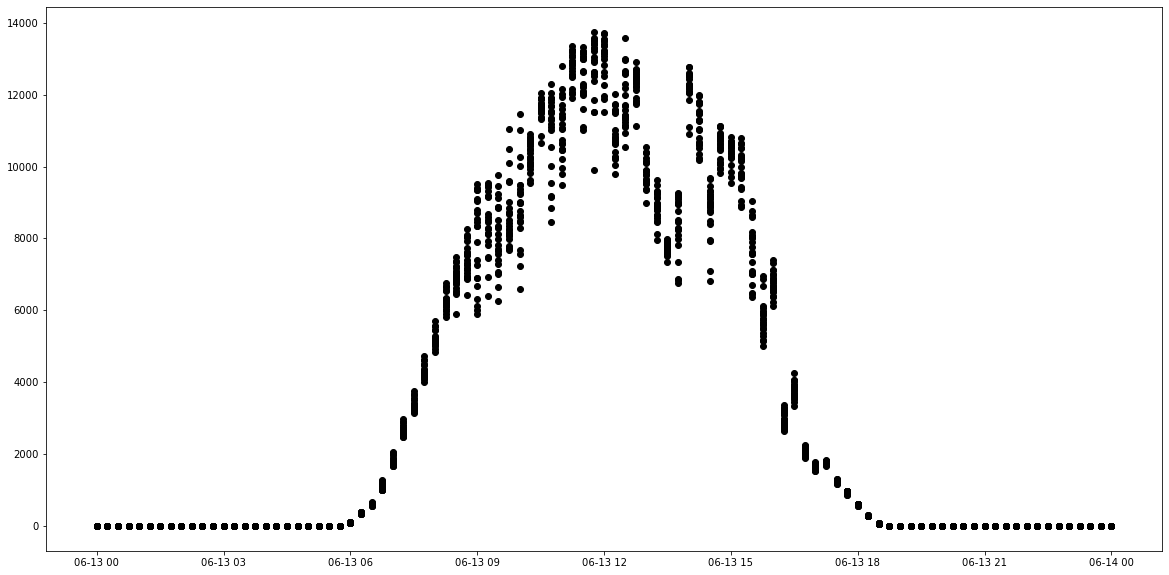

In [13]:
plot_day_dc_mean_std('2020-06-13 00:00:00', '2020-06-14 00:00:00')

In [47]:
out_dc_invs = {}
for dayofyear in plant_gen['dt'].dt.dayofyear.unique():
    d = datetime(2020, 1, 1) + timedelta(int(dayofyear) - 1)
    year = d.year
    month = d.month if d.month > 9 else '0' + str(d.month)
    day = d.day if d.day > 9 else '0' + str(d.day)
    try:
        invs = find_outliers_dc(f'{year}-{month}-{day} 00:00:00', f'{year}-{month}-{day} 23:59:00')
        for k in invs.keys():
            if k in out_dc_invs:
                out_dc_invs[k]+=invs[k]
            else:
                out_dc_invs[k] =invs[k]
        print(f'{year}-{month}-{day}', invs)
    except Exception as e:
        print(f'{year}-{month}-{day} 00:00:00', e)

2020-05-15 {'VHMLBKoKgIrUVDU': 1, 'z9Y9gH1T5YWrNuG': 1, 'YxYtjZvoooNbGkE': 1}
2020-05-16 {}
2020-05-17 {'1BY6WEcLGh8j5v7': 2, 'adLQvlD726eNBSB': 1}
2020-05-18 {'ZnxXDlPa8U1GXgE': 1, 'adLQvlD726eNBSB': 1, 'rGa61gmuvPhdLxV': 1}
2020-05-19 {}
2020-05-20 {'ZnxXDlPa8U1GXgE': 1, 'bvBOhCH3iADSZry': 6}
2020-05-21 {}
2020-05-22 {'McdE0feGgRqW7Ca': 1, 'rGa61gmuvPhdLxV': 10}
2020-05-23 {'1BY6WEcLGh8j5v7': 1, 'rGa61gmuvPhdLxV': 6, 'uHbuxQJl8lW7ozc': 1}
2020-05-24 {'uHbuxQJl8lW7ozc': 1, 'zBIq5rxdHJRwDNY': 1}
2020-05-25 {'ZnxXDlPa8U1GXgE': 1, 'ih0vzX44oOqAx2f': 2}
2020-05-26 {}
2020-05-27 {}
2020-05-28 {'1BY6WEcLGh8j5v7': 1}
2020-05-29 {}
2020-05-30 {'bvBOhCH3iADSZry': 4}
2020-05-31 {'adLQvlD726eNBSB': 1, 'bvBOhCH3iADSZry': 3}
2020-06-01 {'bvBOhCH3iADSZry': 1}
2020-06-02 {'bvBOhCH3iADSZry': 2}
2020-06-03 {'bvBOhCH3iADSZry': 1}
2020-06-04 {}
2020-06-05 {'uHbuxQJl8lW7ozc': 1}
2020-06-06 {}
2020-06-07 {'uHbuxQJl8lW7ozc': 1}
2020-06-08 {'1BY6WEcLGh8j5v7': 1}
2020-06-09 {'1BY6WEcLGh8j5v7': 1}
2020-06-10 

In [49]:
out_dc_invs, out_invs # it looks like there is no difference between AC/DC in terms of outliers 

({'VHMLBKoKgIrUVDU': 1,
  'z9Y9gH1T5YWrNuG': 1,
  'YxYtjZvoooNbGkE': 1,
  '1BY6WEcLGh8j5v7': 8,
  'adLQvlD726eNBSB': 5,
  'ZnxXDlPa8U1GXgE': 3,
  'rGa61gmuvPhdLxV': 17,
  'bvBOhCH3iADSZry': 29,
  'McdE0feGgRqW7Ca': 1,
  'uHbuxQJl8lW7ozc': 4,
  'zBIq5rxdHJRwDNY': 2,
  'ih0vzX44oOqAx2f': 2,
  '3PZuoBAID5Wc2HD': 1,
  'WRmjgnKYAwPKWDb': 1},
 {'VHMLBKoKgIrUVDU': 1,
  'z9Y9gH1T5YWrNuG': 1,
  'YxYtjZvoooNbGkE': 1,
  '1BY6WEcLGh8j5v7': 8,
  'adLQvlD726eNBSB': 5,
  'ZnxXDlPa8U1GXgE': 3,
  'rGa61gmuvPhdLxV': 17,
  'bvBOhCH3iADSZry': 29,
  'McdE0feGgRqW7Ca': 1,
  'uHbuxQJl8lW7ozc': 4,
  'zBIq5rxdHJRwDNY': 2,
  'ih0vzX44oOqAx2f': 2,
  '3PZuoBAID5Wc2HD': 1,
  'WRmjgnKYAwPKWDb': 1})

In [23]:
inv1 = plant_gen[plant_gen['SOURCE_KEY'] == 'bvBOhCH3iADSZry']

<ipython-input-187-eb9942f2da6e>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.scatter(plant_gen['2020-06-12'].index, plant_gen['2020-06-12']['DC_POWER'])
<ipython-input-187-eb9942f2da6e>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.scatter(inv1['2020-06-12'].index, inv1['2020-06-12']['DC_POWER'], color='red')


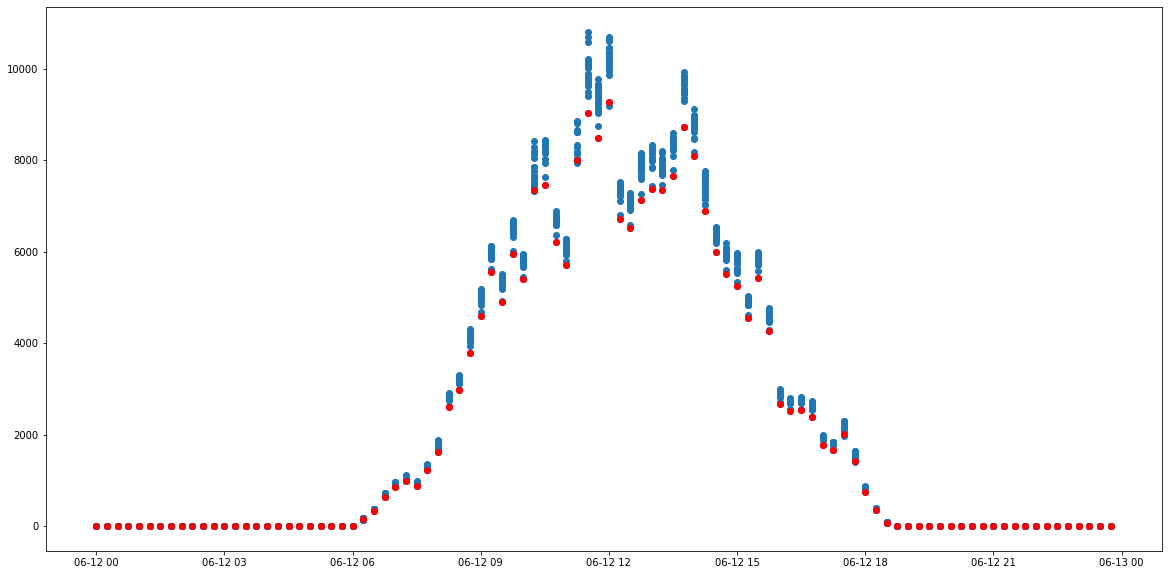

In [187]:
plt.figure(figsize=(20, 10))
plt.scatter(plant_gen['2020-06-12'].index, plant_gen['2020-06-12']['DC_POWER'])
plt.scatter(inv1['2020-06-12'].index, inv1['2020-06-12']['DC_POWER'], color='red')

In [14]:
merged_df = pd.merge(plant_gen, plant_weat, how='inner', on='DATE_TIME')

In [18]:
def plot_dc_irr(d1, d2):
    date = merged_df[d1:d2]
    df = pd.DataFrame(columns=['Datetime', 'MeanDC', 'std', 'IRRADIATION'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['DC_POWER'].mean(), gp['DC_POWER'].std(), gp['IRRADIATION'].mean()]
        i+=1
    plt.figure(figsize=(20, 10))
    for key in date['SOURCE_KEY_x'].unique():
        plt.plot(date[date['SOURCE_KEY_x'] == key].index, date[date['SOURCE_KEY_x'] == key]['DC_POWER'], 'o', color='black')
    print(df.corr())
    print("df['MeanDC'] std", df['MeanDC'].std())
    print("df['std'] std", df['std'].std())
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    #plt.plot(df['Datetime'], df['MeanDC'], color='red', label='MeanDC')
    #plt.plot(df['Datetime'], df['MeanDC'] + 3 * df['std'], color='blue', label='MeanDC + 3std')
    #plt.plot(df['Datetime'], df['MeanDC'] - 3 * df['std'], color='green', label='MeanDC - 3std')
    #plt.plot(df['Datetime'], df['IRRADIATION'] * 10000, color='m', label='IRRADIATION times 10000')
    plt.title(d1)
    plt.legend()
    plt.show()
    return (df['std']/df['MeanDC']).mean()

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.775176     0.996814
std          0.775176  1.000000     0.777053
IRRADIATION  0.996814  0.777053     1.000000
df['MeanDC'] std 3388.9504407667846
df['std'] std 390.66766317109557


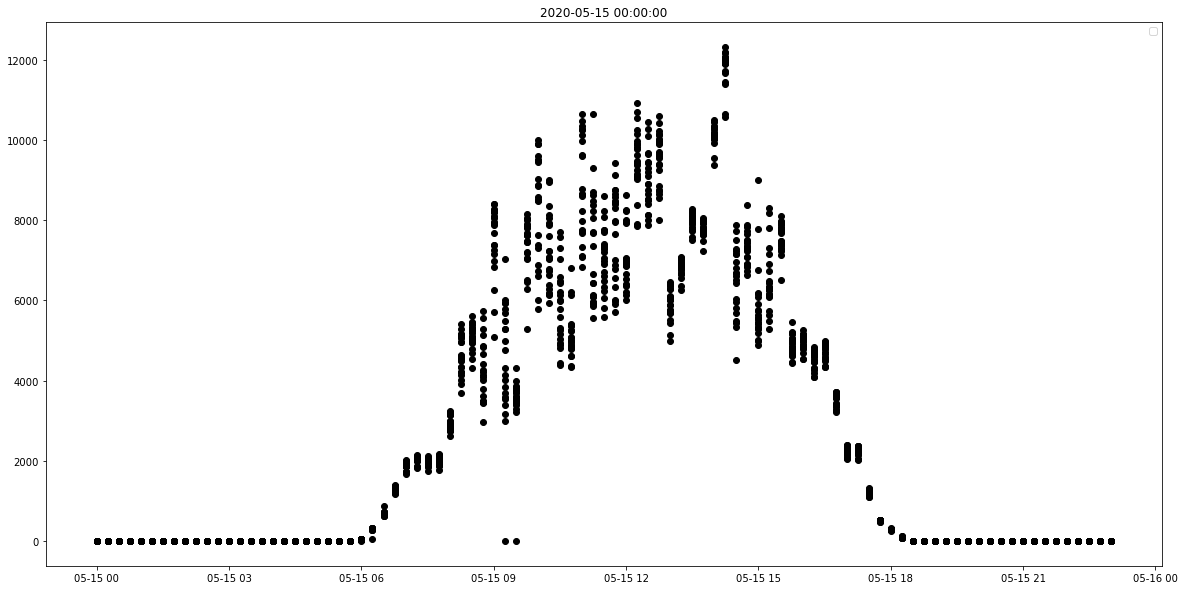

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.915774     0.999354
std          0.915774  1.000000     0.916854
IRRADIATION  0.999354  0.916854     1.000000
df['MeanDC'] std 3553.1416961969544
df['std'] std 210.68593956582748


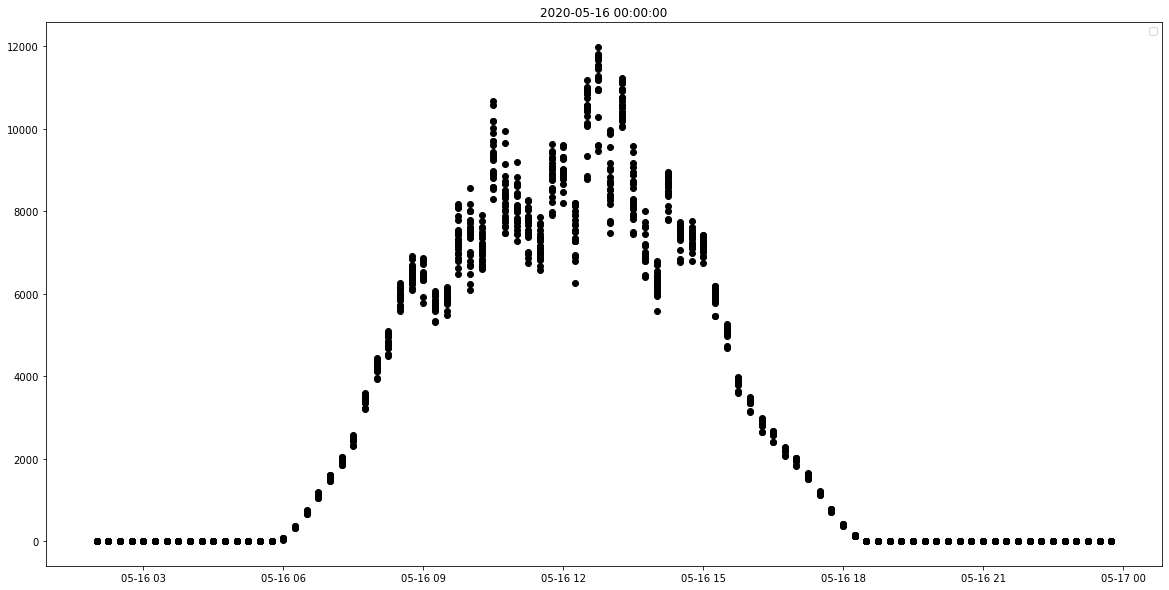

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.846814     0.998046
std          0.846814  1.000000     0.850566
IRRADIATION  0.998046  0.850566     1.000000
df['MeanDC'] std 4096.314675558264
df['std'] std 361.5256403701598


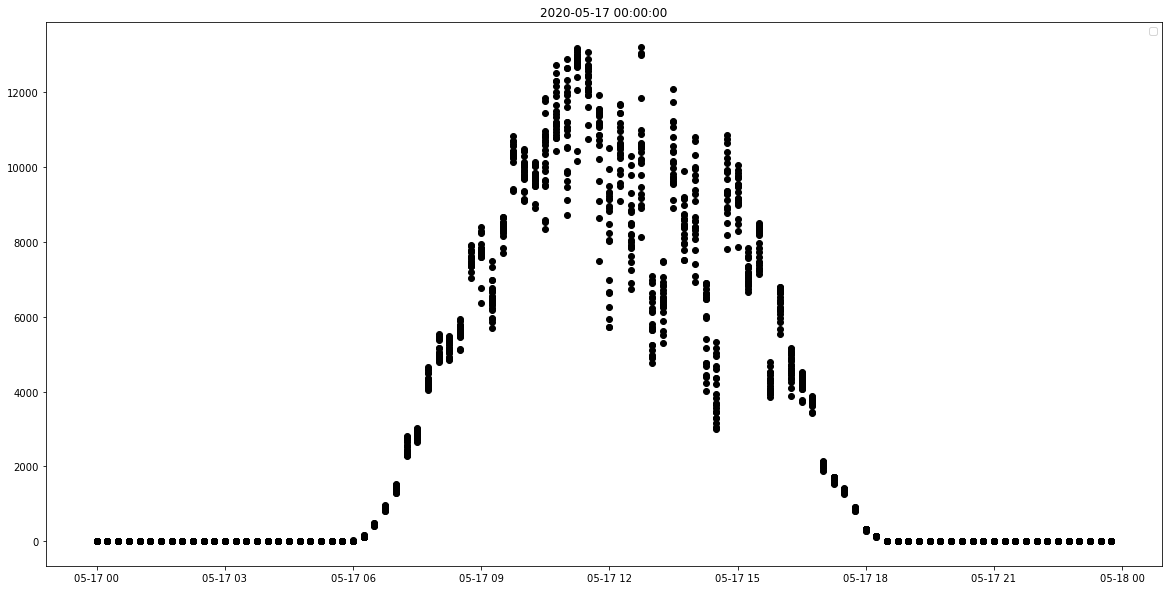

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.968102     0.998950
std          0.968102  1.000000     0.972276
IRRADIATION  0.998950  0.972276     1.000000
df['MeanDC'] std 3249.770329308318
df['std'] std 110.72344951582278


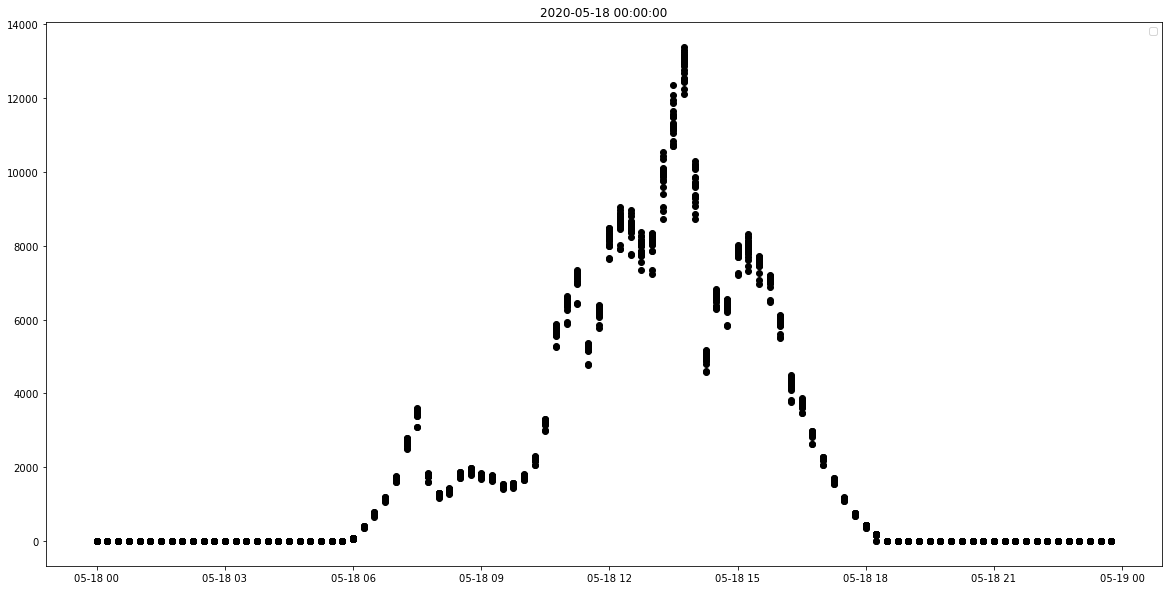

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.873966     0.999078
std          0.873966  1.000000     0.880437
IRRADIATION  0.999078  0.880437     1.000000
df['MeanDC'] std 3586.2889409450995
df['std'] std 211.88106048935236


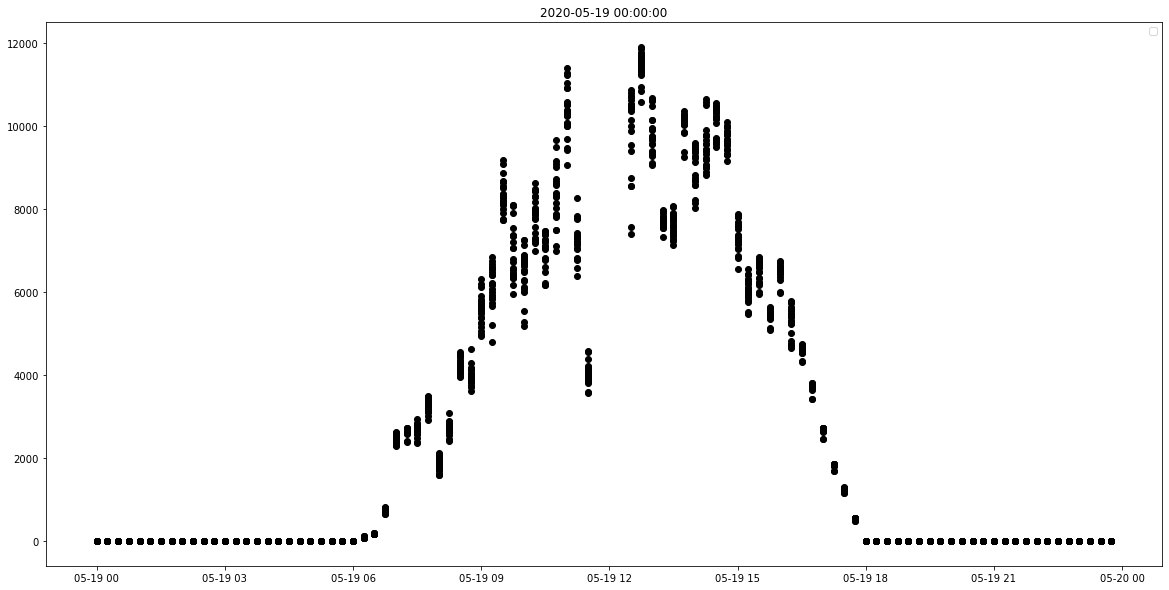

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.972325     0.999771
std          0.972325  1.000000     0.974262
IRRADIATION  0.999771  0.974262     1.000000
df['MeanDC'] std 4761.87915521023
df['std'] std 139.4622415555538


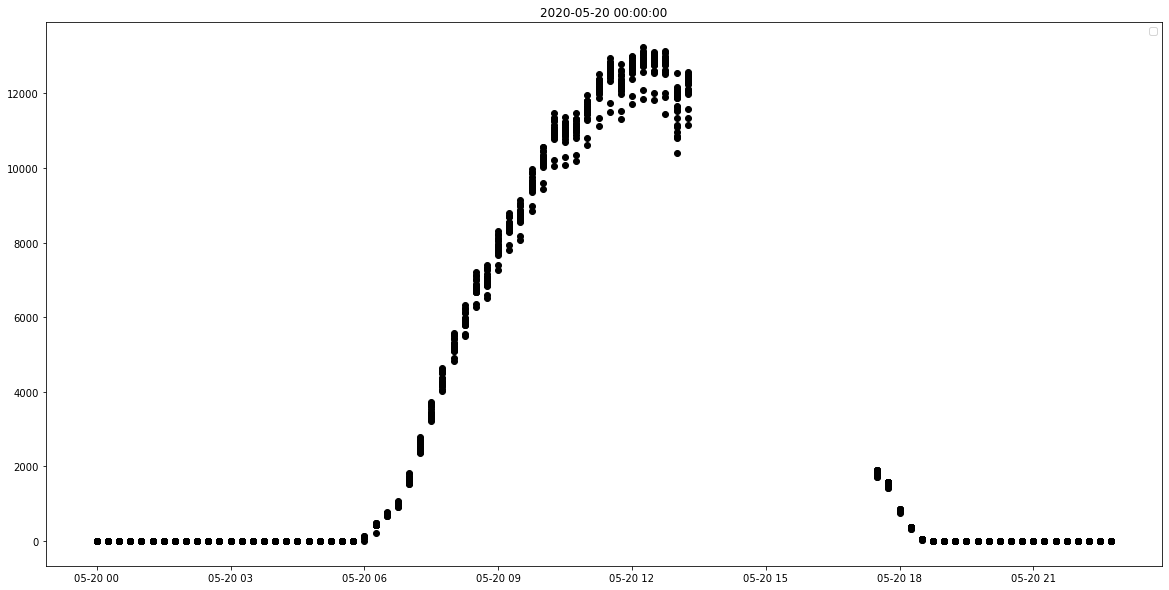

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.835537     0.992986
std          0.835537  1.000000     0.841584
IRRADIATION  0.992986  0.841584     1.000000
df['MeanDC'] std 4593.739799811574
df['std'] std 407.08941755438934


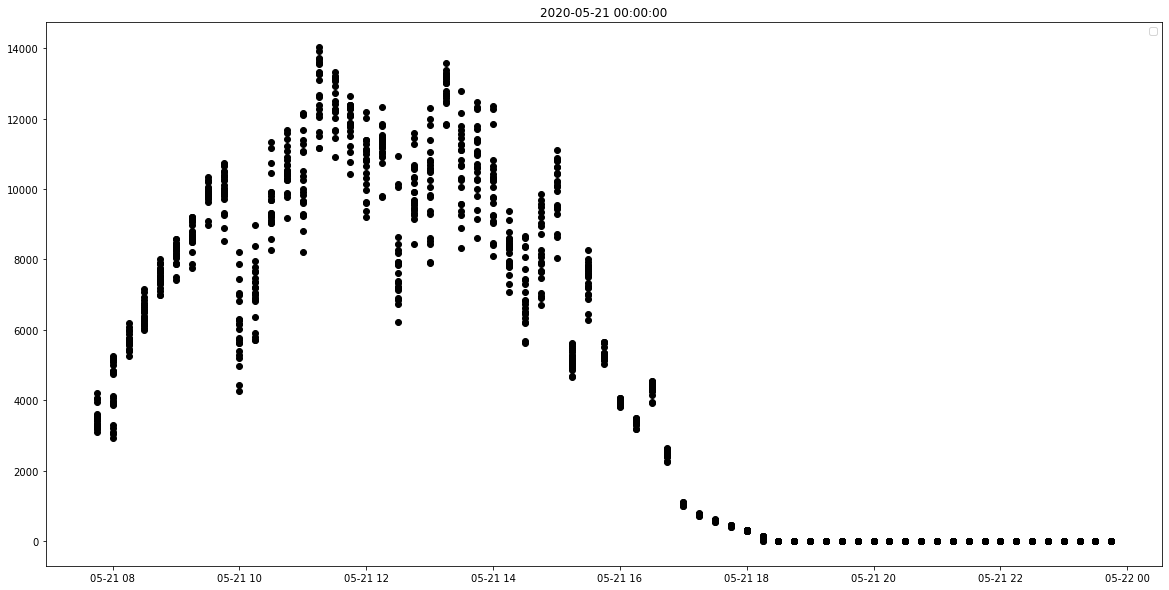

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.784285     0.997665
std          0.784285  1.000000     0.774873
IRRADIATION  0.997665  0.774873     1.000000
df['MeanDC'] std 4073.3157632706425
df['std'] std 419.6995738442564


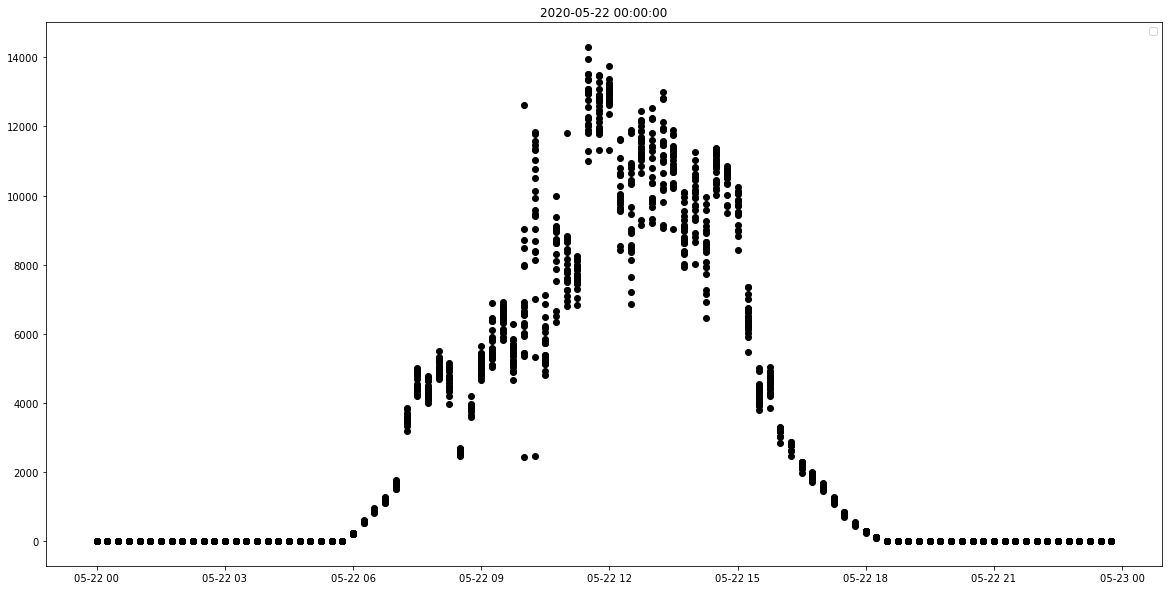

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.776287     0.998006
std          0.776287  1.000000     0.779894
IRRADIATION  0.998006  0.779894     1.000000
df['MeanDC'] std 4588.145608654952
df['std'] std 279.5570762432054


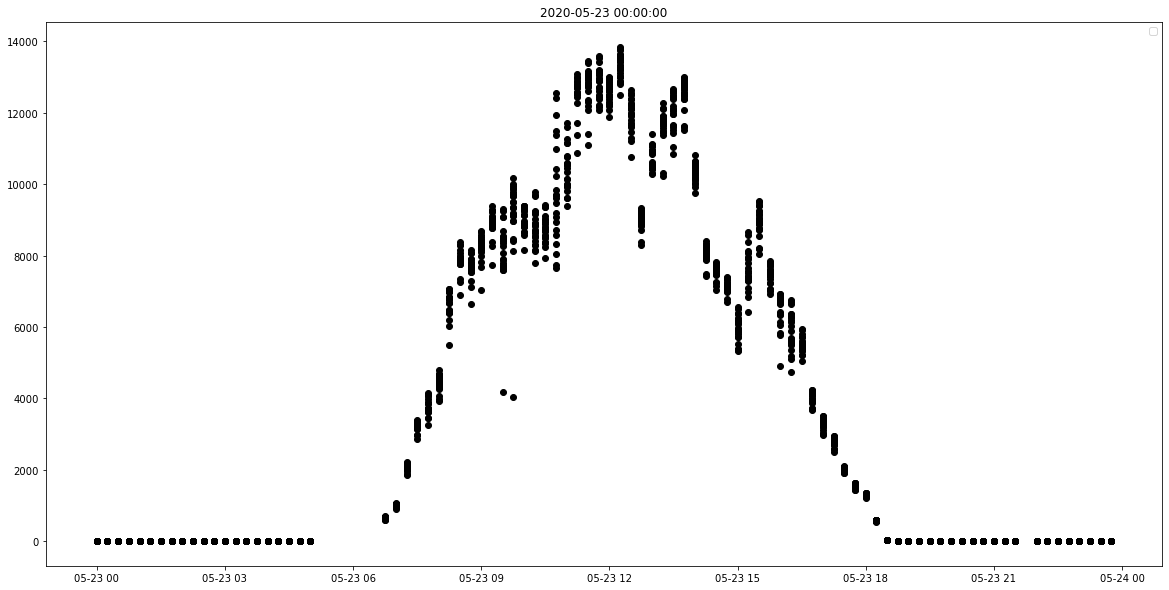

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.802164     0.996406
std          0.802164  1.000000     0.807457
IRRADIATION  0.996406  0.807457     1.000000
df['MeanDC'] std 4355.990812887892
df['std'] std 404.09285596768837


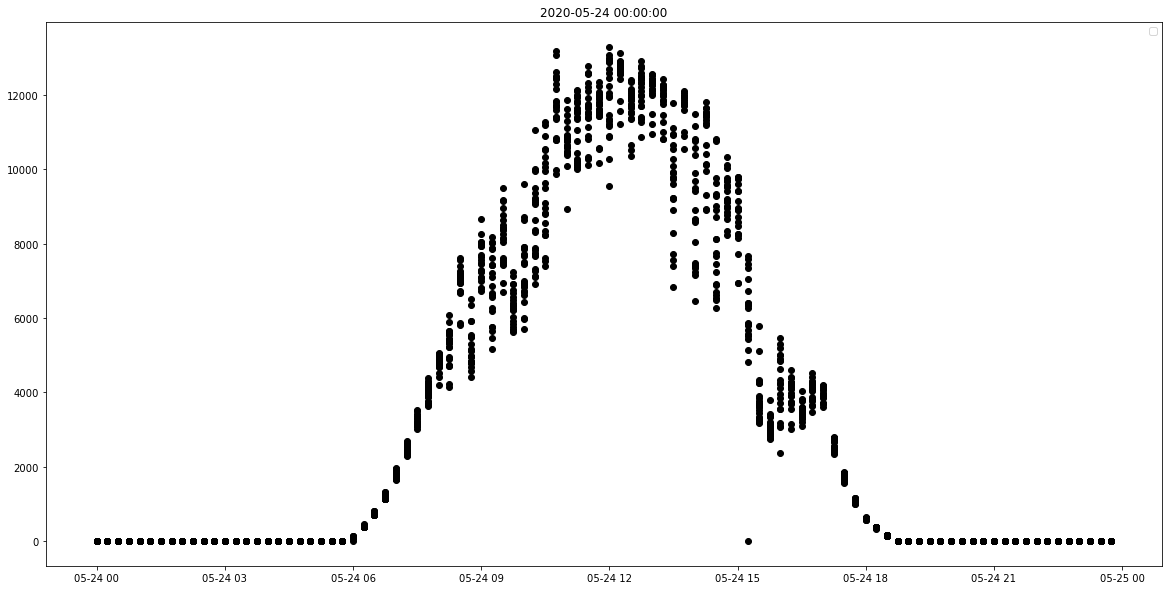

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.684295     0.999267
std          0.684295  1.000000     0.688370
IRRADIATION  0.999267  0.688370     1.000000
df['MeanDC'] std 4897.157088248429
df['std'] std 304.4495387101704


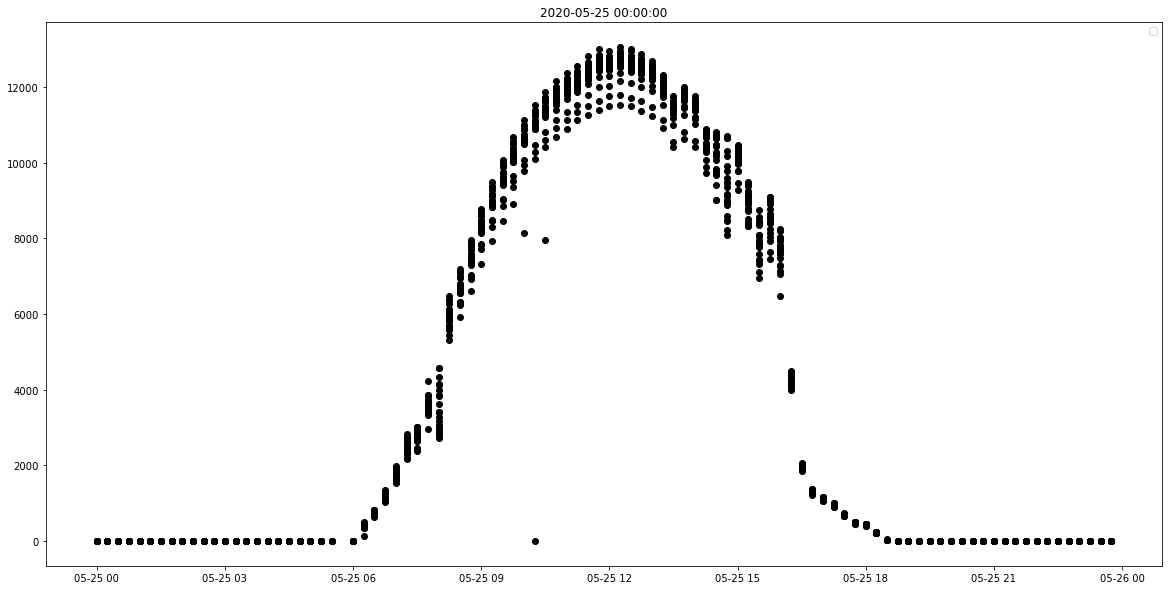

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.831381     0.995786
std          0.831381  1.000000     0.811138
IRRADIATION  0.995786  0.811138     1.000000
df['MeanDC'] std 4249.6276479080925
df['std'] std 386.18755824741436


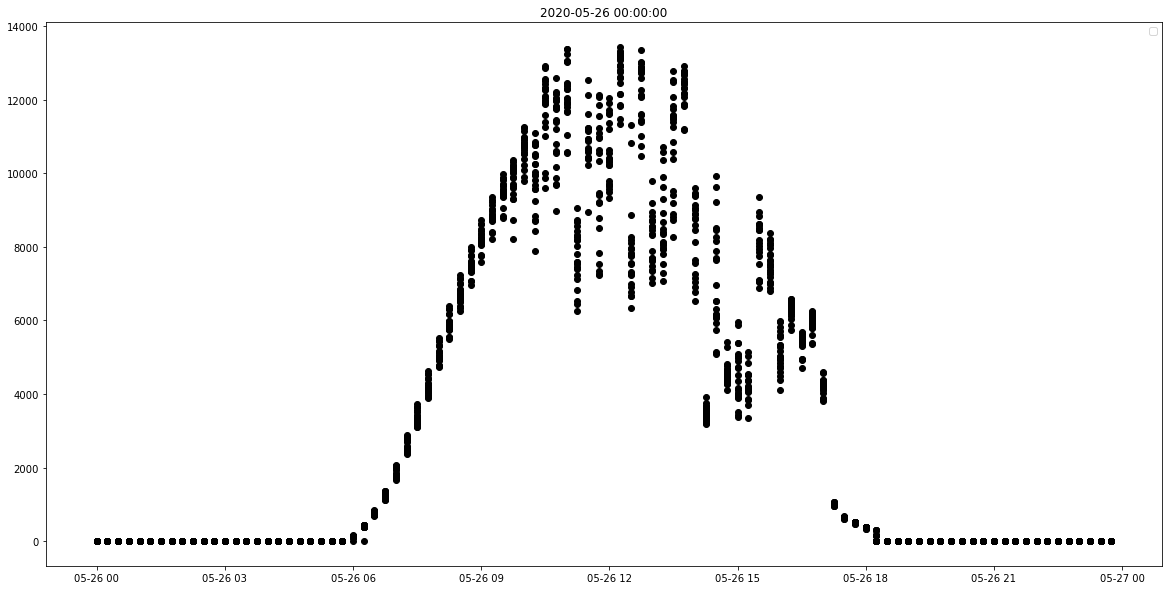

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.884426     0.997221
std          0.884426  1.000000     0.887170
IRRADIATION  0.997221  0.887170     1.000000
df['MeanDC'] std 3590.657388831978
df['std'] std 388.0476041478146


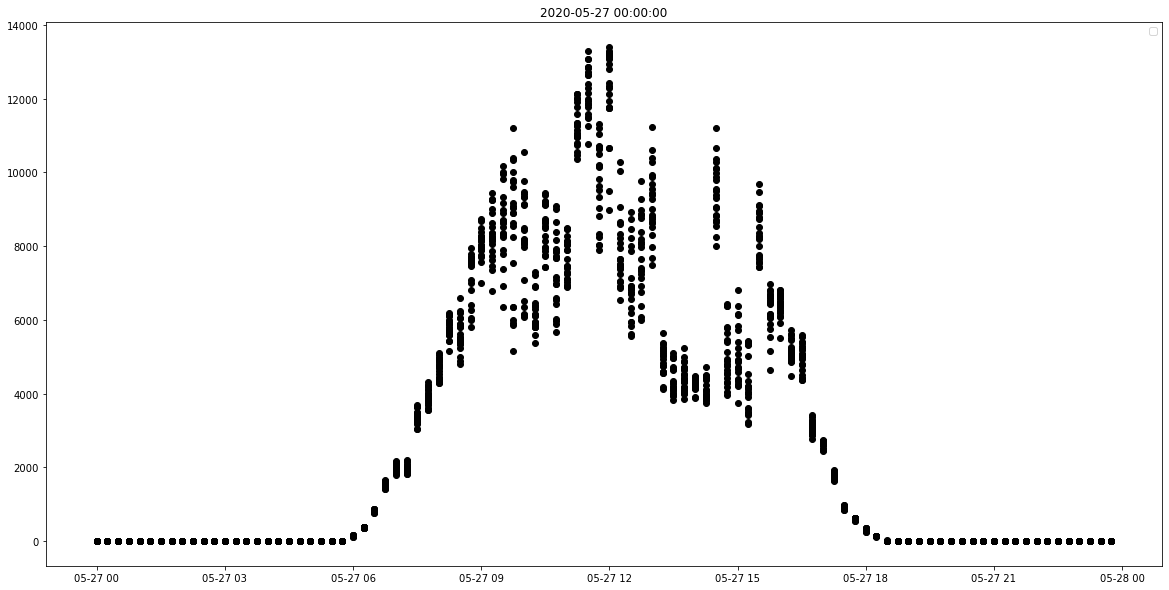

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.820169     0.997973
std          0.820169  1.000000     0.818535
IRRADIATION  0.997973  0.818535     1.000000
df['MeanDC'] std 4558.420343356679
df['std'] std 322.42570716865004


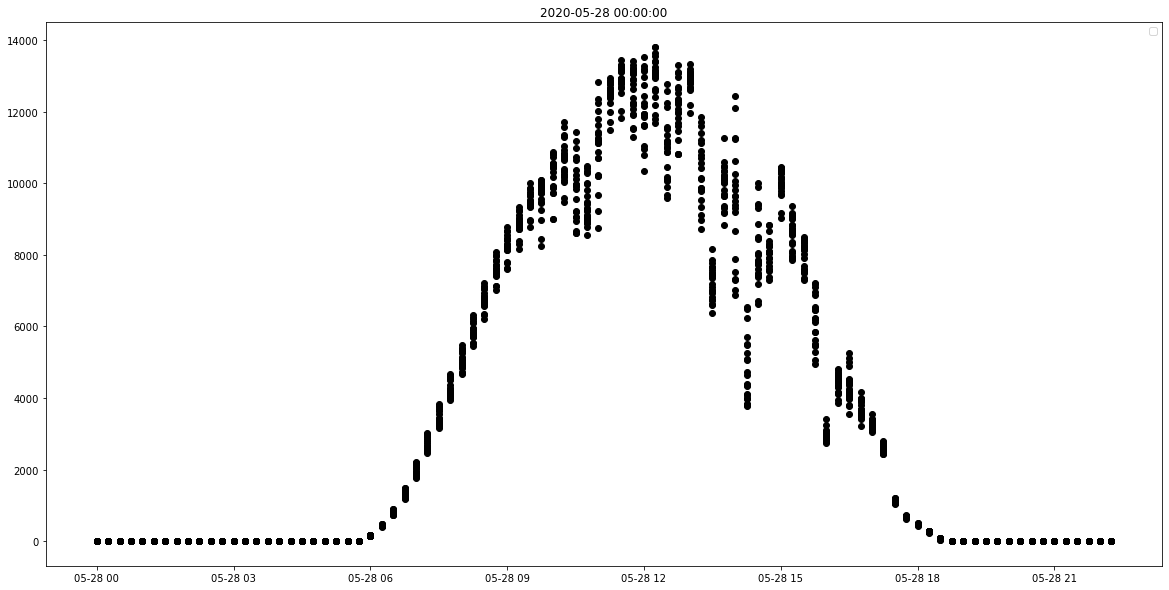

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.776970     0.998107
std          0.776970  1.000000     0.779831
IRRADIATION  0.998107  0.779831     1.000000
df['MeanDC'] std 4565.301001733077
df['std'] std 251.54906639544376


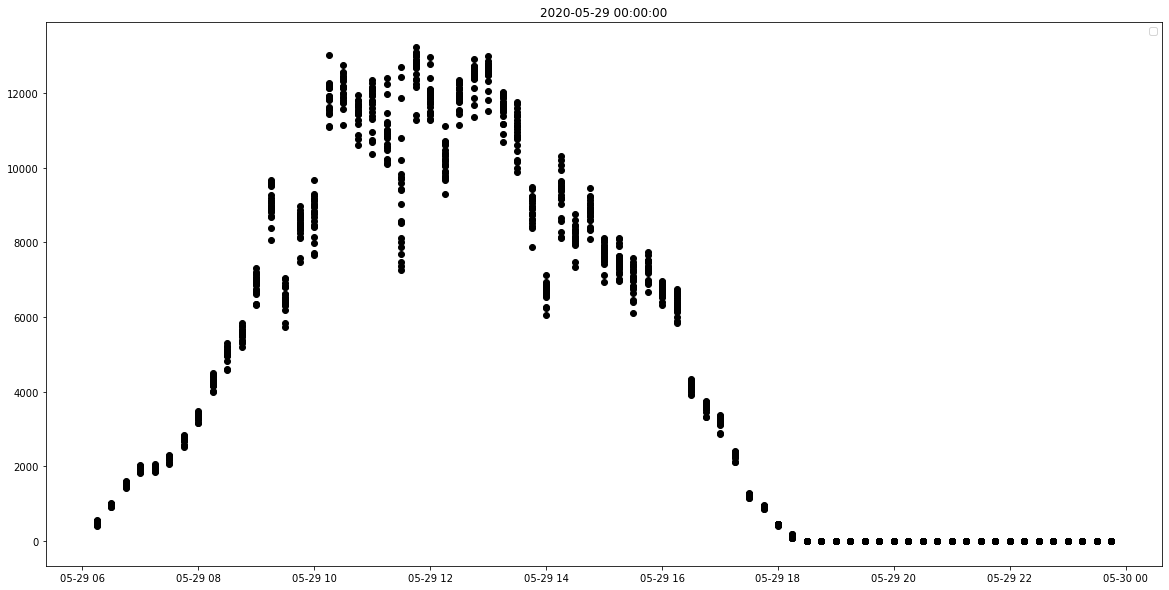

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.931595     0.995814
std          0.931595  1.000000     0.933471
IRRADIATION  0.995814  0.933471     1.000000
df['MeanDC'] std 4060.858403923237
df['std'] std 162.3795147486902


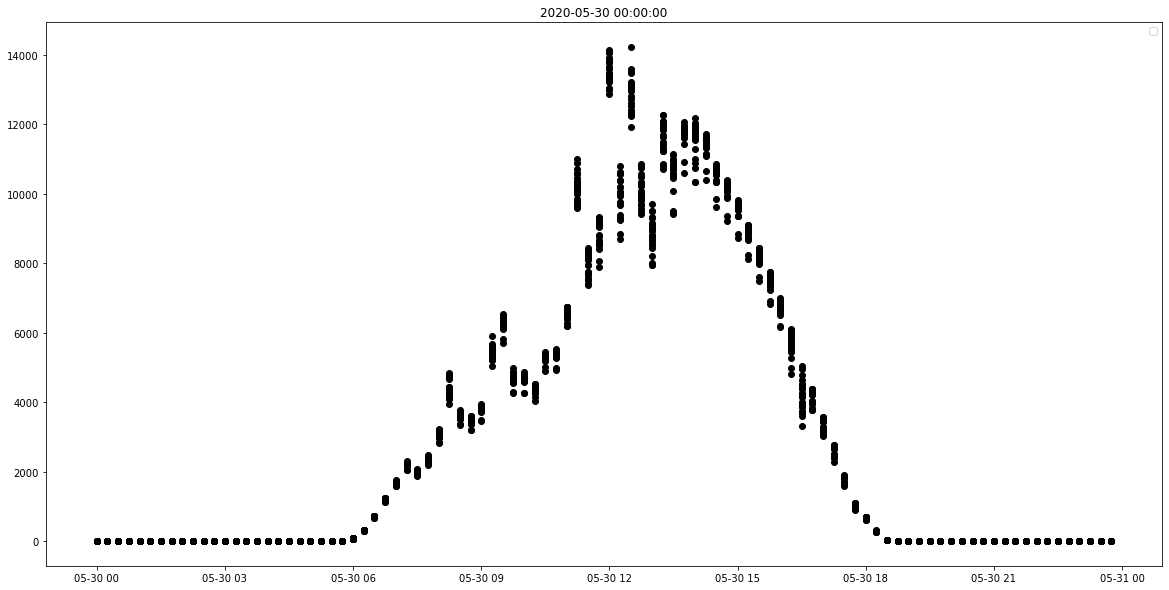

No handles with labels found to put in legend.


              MeanDC       std  IRRADIATION
MeanDC       1.00000  0.849340     0.994110
std          0.84934  1.000000     0.817287
IRRADIATION  0.99411  0.817287     1.000000
df['MeanDC'] std 3599.69250163633
df['std'] std 473.5992914310802


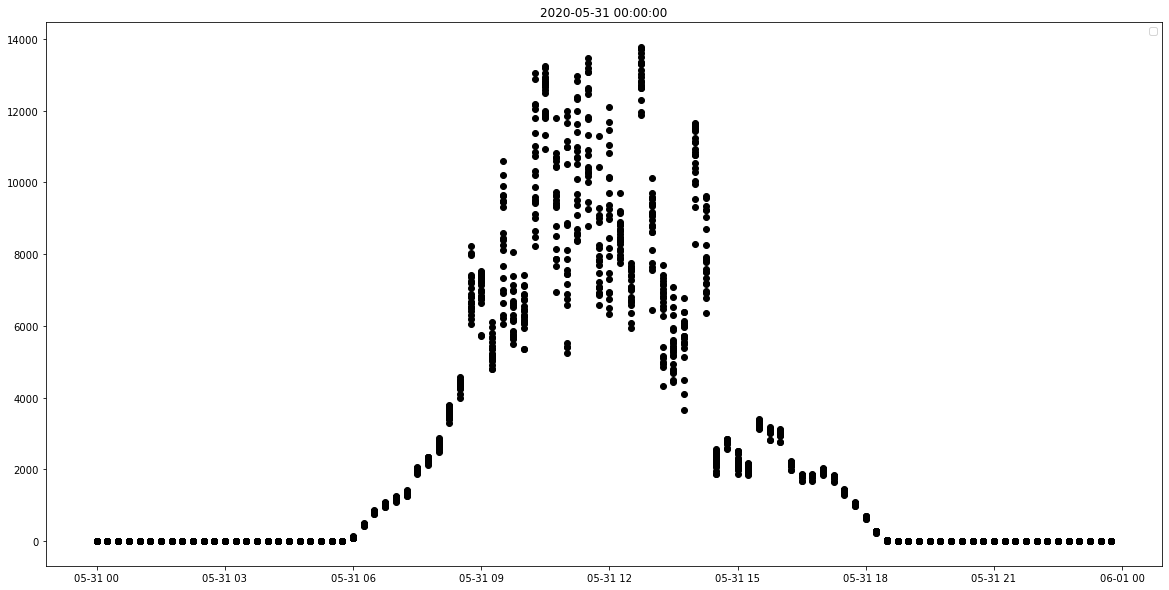

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.845737     0.986472
std          0.845737  1.000000     0.799696
IRRADIATION  0.986472  0.799696     1.000000
df['MeanDC'] std 3430.6624719274537
df['std'] std 422.43303073986186


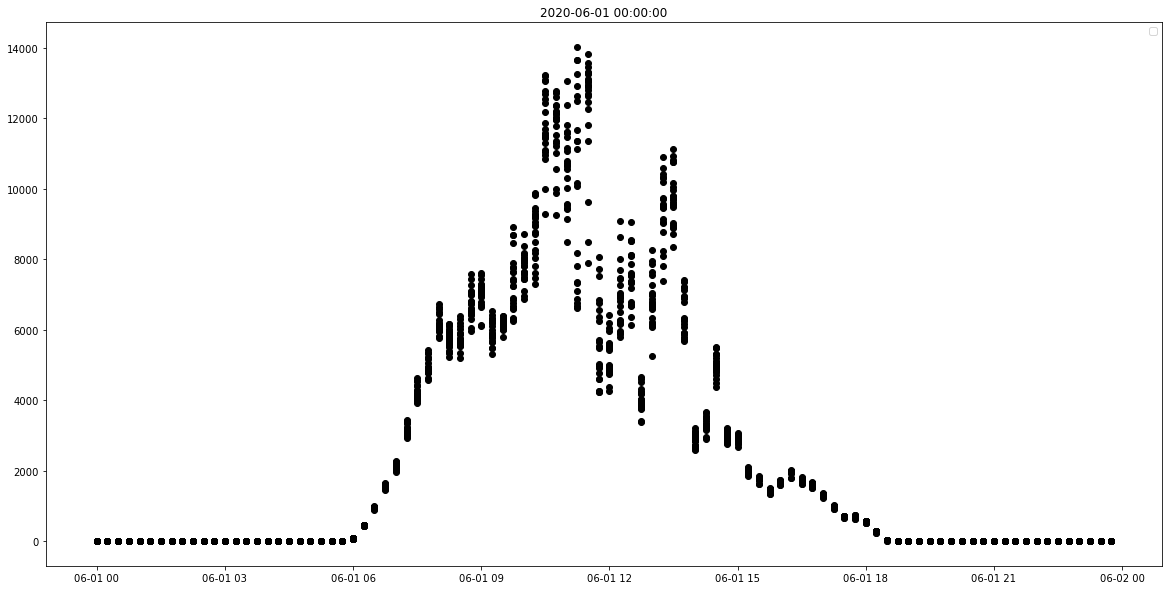

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.838873     0.998865
std          0.838873  1.000000     0.843915
IRRADIATION  0.998865  0.843915     1.000000
df['MeanDC'] std 4000.862617740991
df['std'] std 237.1622318746867


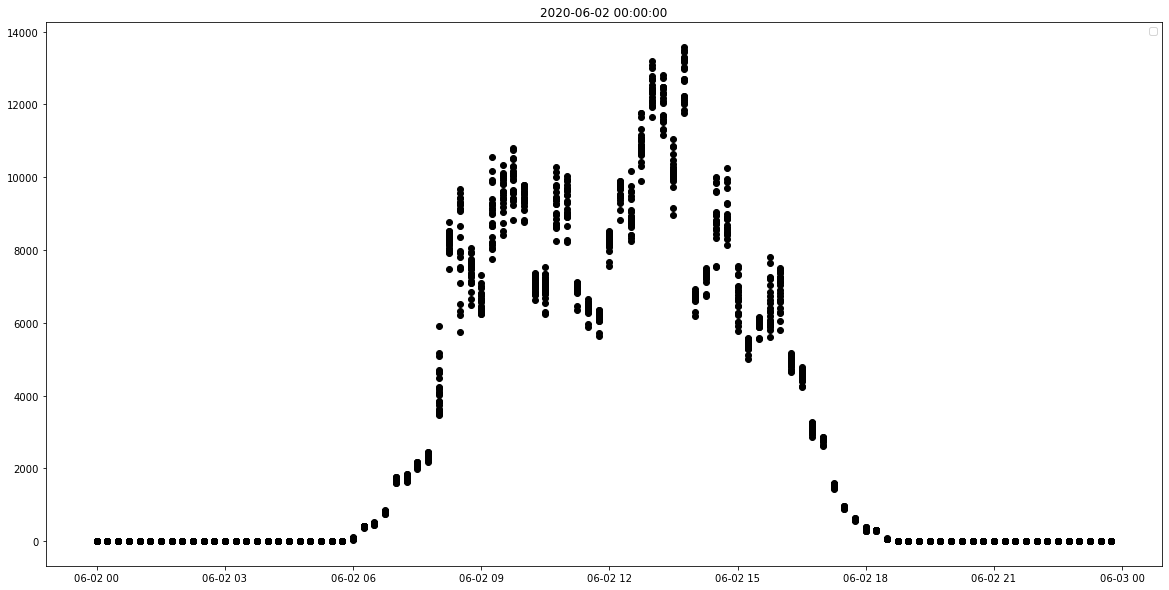

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.882967     0.999084
std          0.882967  1.000000     0.885321
IRRADIATION  0.999084  0.885321     1.000000
df['MeanDC'] std 4149.362462828819
df['std'] std 181.55815585641557


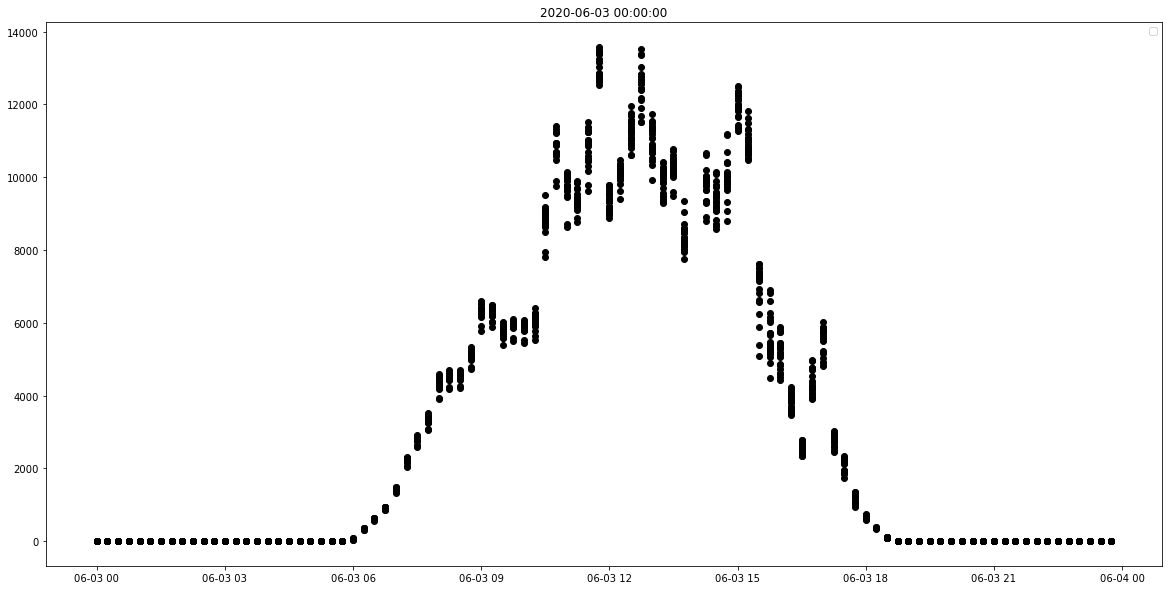

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.875545     0.995933
std          0.875545  1.000000     0.877386
IRRADIATION  0.995933  0.877386     1.000000
df['MeanDC'] std 4233.120664057885
df['std'] std 331.0562483963919


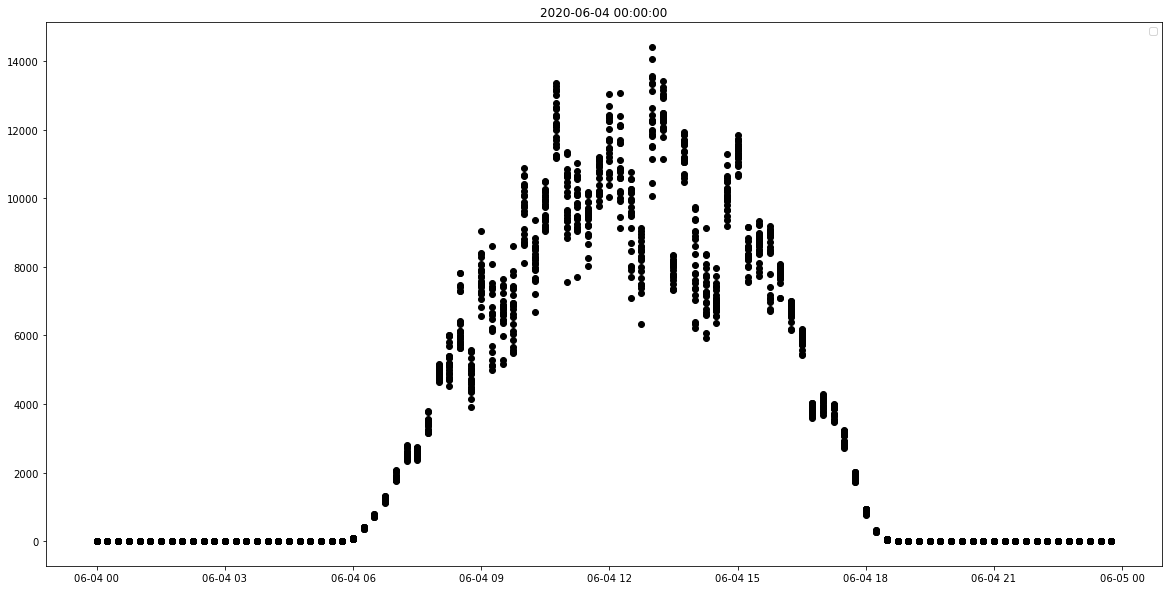

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.830111      0.99618
std          0.830111  1.000000      0.84759
IRRADIATION  0.996180  0.847590      1.00000
df['MeanDC'] std 4104.004814899696
df['std'] std 332.17766255544933


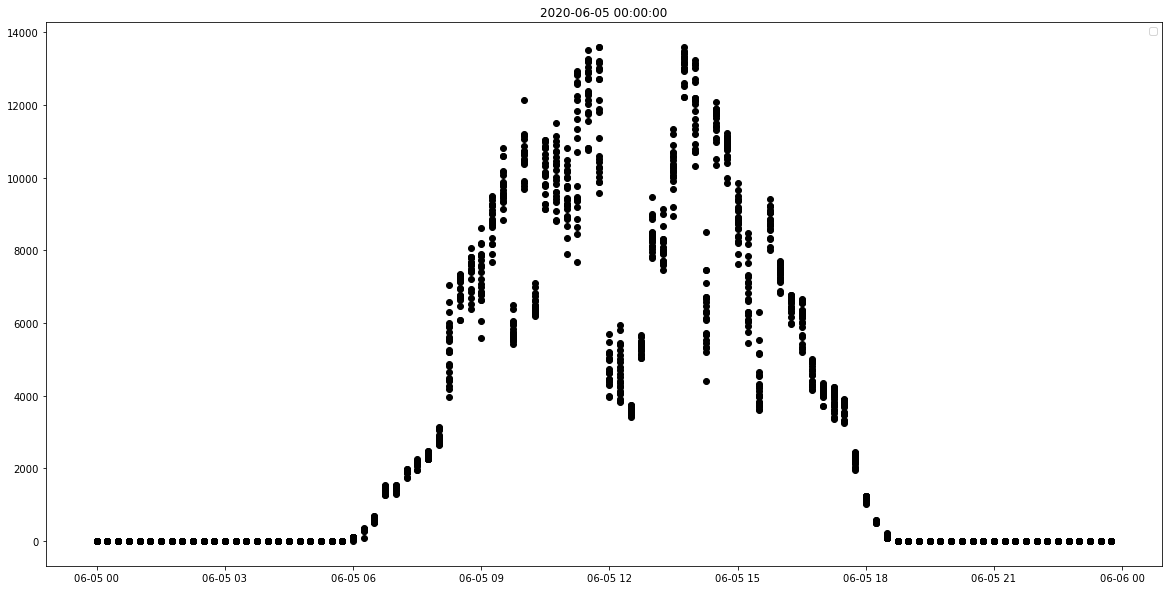

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.898486     0.994202
std          0.898486  1.000000     0.897666
IRRADIATION  0.994202  0.897666     1.000000
df['MeanDC'] std 3701.7005697094232
df['std'] std 328.2708683047274


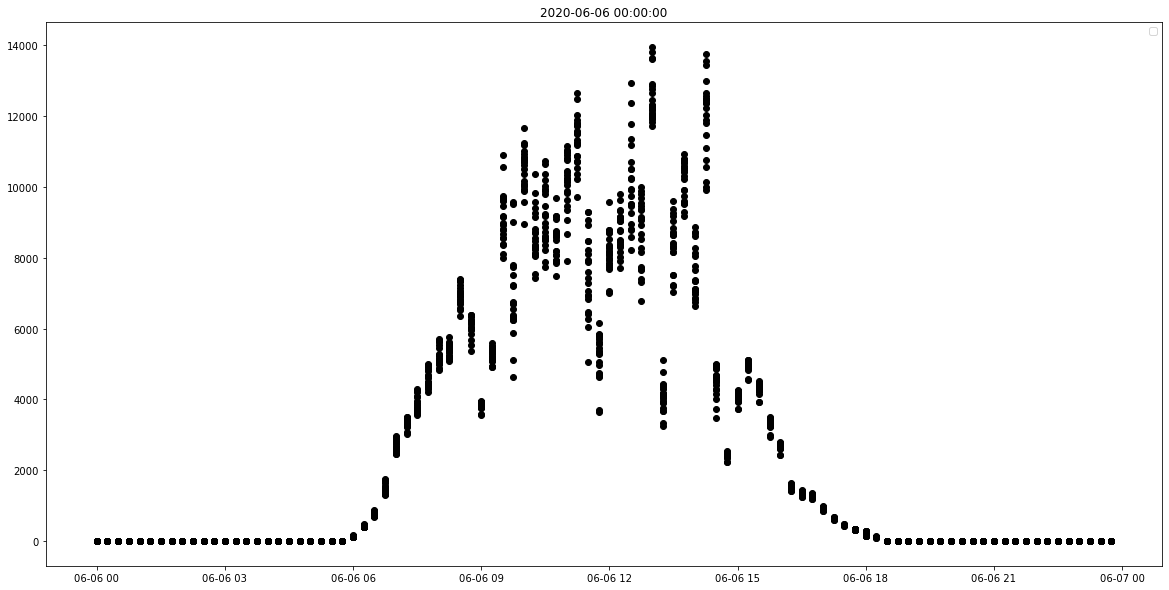

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.530480     0.984711
std          0.530480  1.000000     0.654579
IRRADIATION  0.984711  0.654579     1.000000
df['MeanDC'] std 4178.8622187589235
df['std'] std 1344.5711531095553


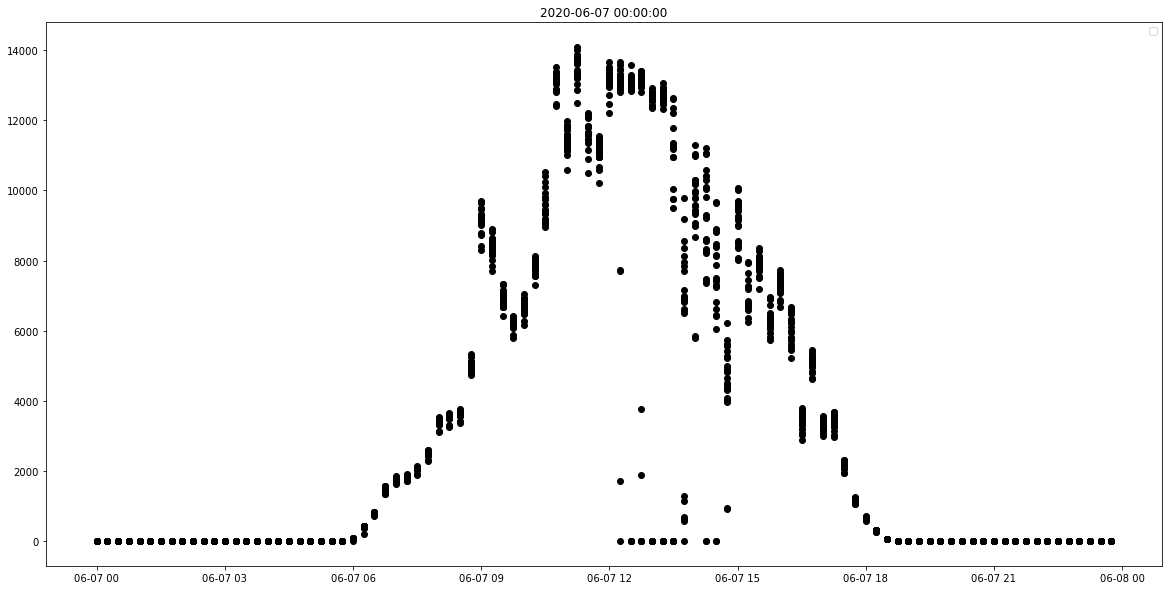

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.891276     0.998441
std          0.891276  1.000000     0.896106
IRRADIATION  0.998441  0.896106     1.000000
df['MeanDC'] std 4442.312661780685
df['std'] std 319.7010024199802


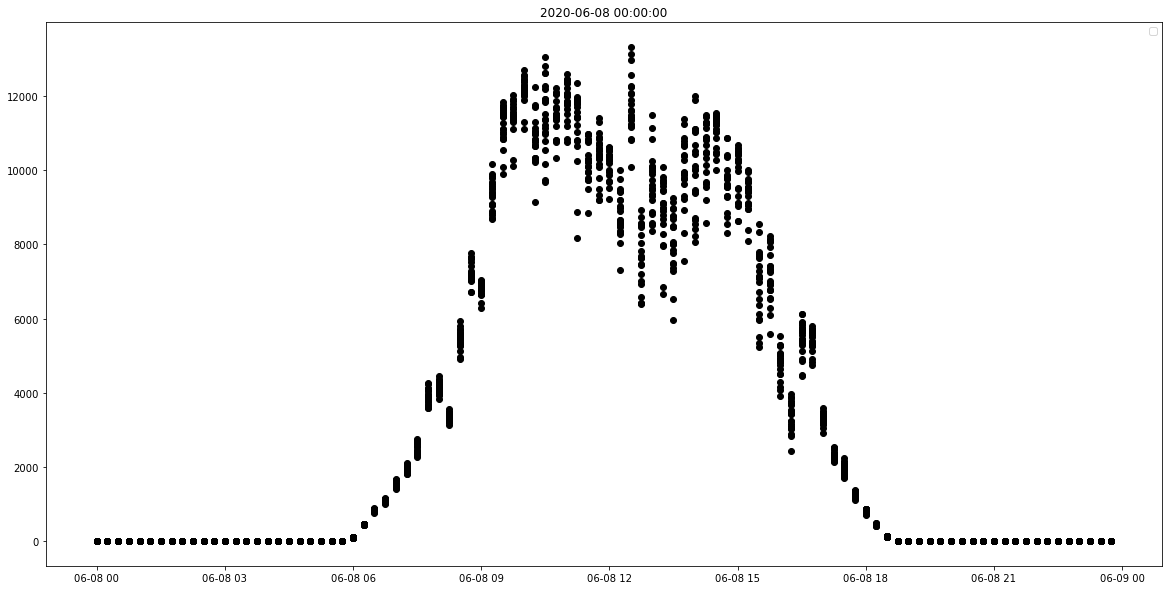

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.853426     0.997829
std          0.853426  1.000000     0.861336
IRRADIATION  0.997829  0.861336     1.000000
df['MeanDC'] std 4191.296268077411
df['std'] std 332.13793628960707


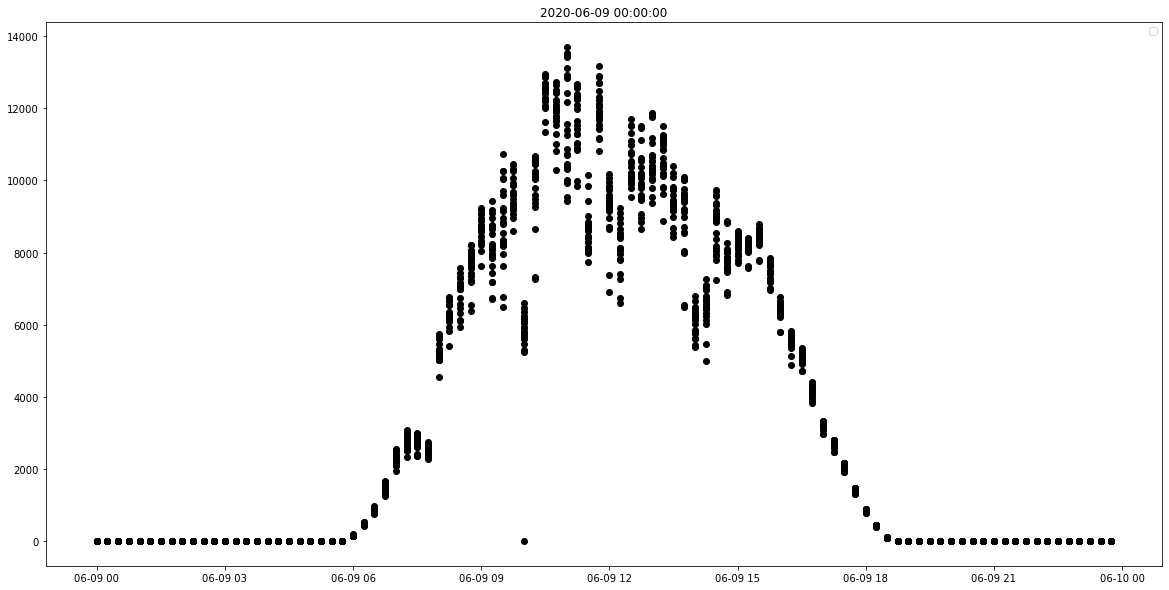

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.873577     0.997300
std          0.873577  1.000000     0.884858
IRRADIATION  0.997300  0.884858     1.000000
df['MeanDC'] std 3638.054659267532
df['std'] std 257.18342469046996


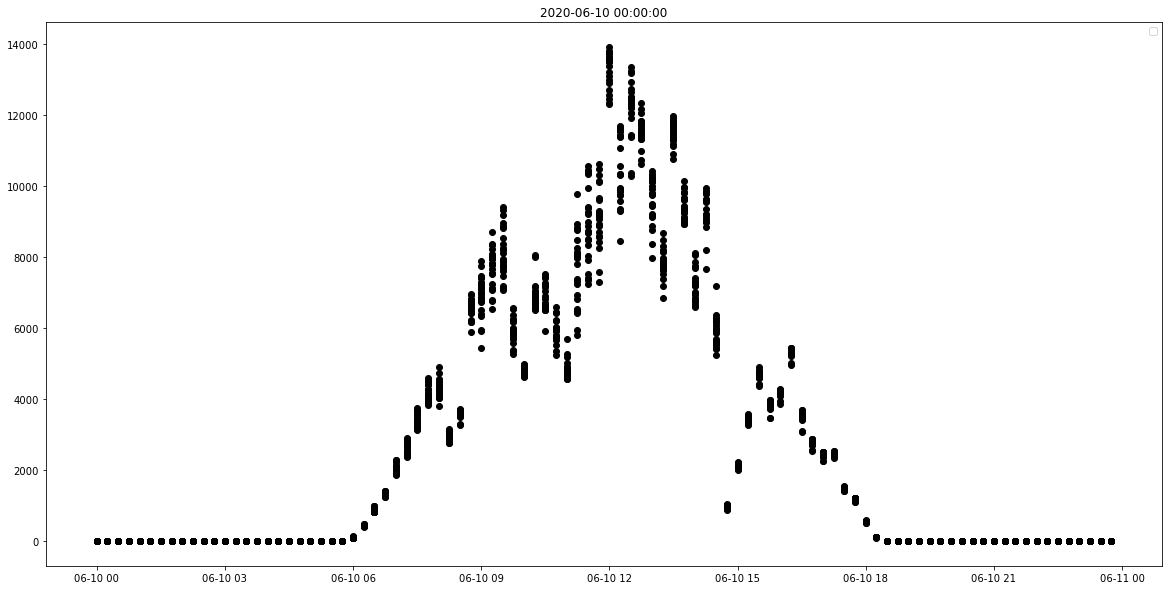

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.930359     0.999513
std          0.930359  1.000000     0.934824
IRRADIATION  0.999513  0.934824     1.000000
df['MeanDC'] std 3078.1934161848008
df['std'] std 116.00852895657458


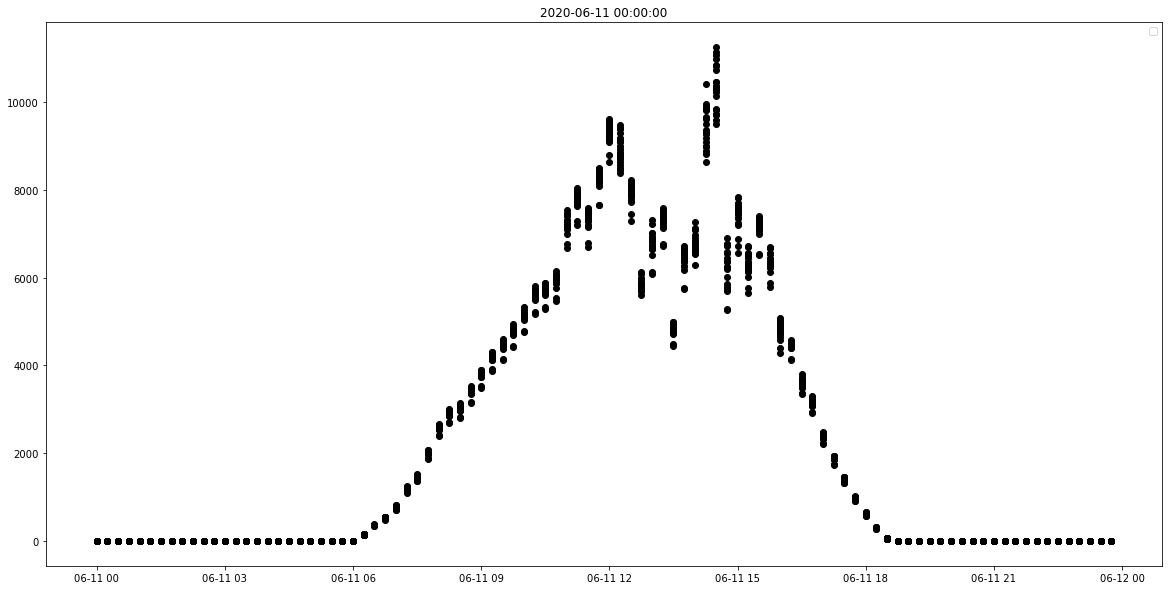

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.973626     0.999491
std          0.973626  1.000000     0.973050
IRRADIATION  0.999491  0.973050     1.000000
df['MeanDC'] std 3247.203931833632
df['std'] std 103.50614223559087


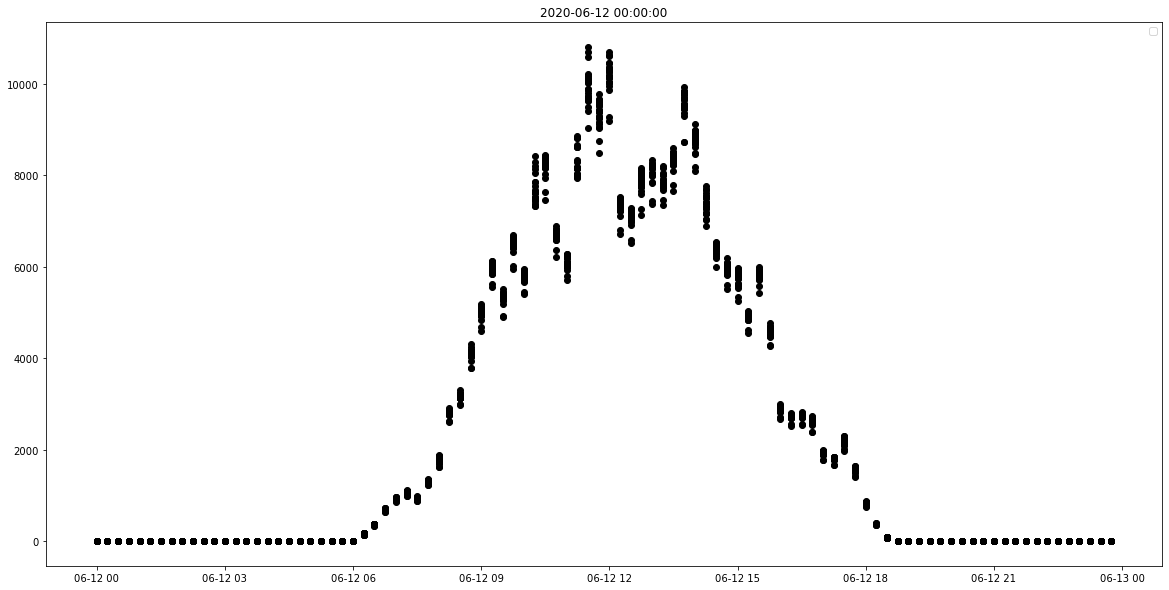

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.846550     0.998146
std          0.846550  1.000000     0.842494
IRRADIATION  0.998146  0.842494     1.000000
df['MeanDC'] std 4599.794735845475
df['std'] std 326.2180285454925


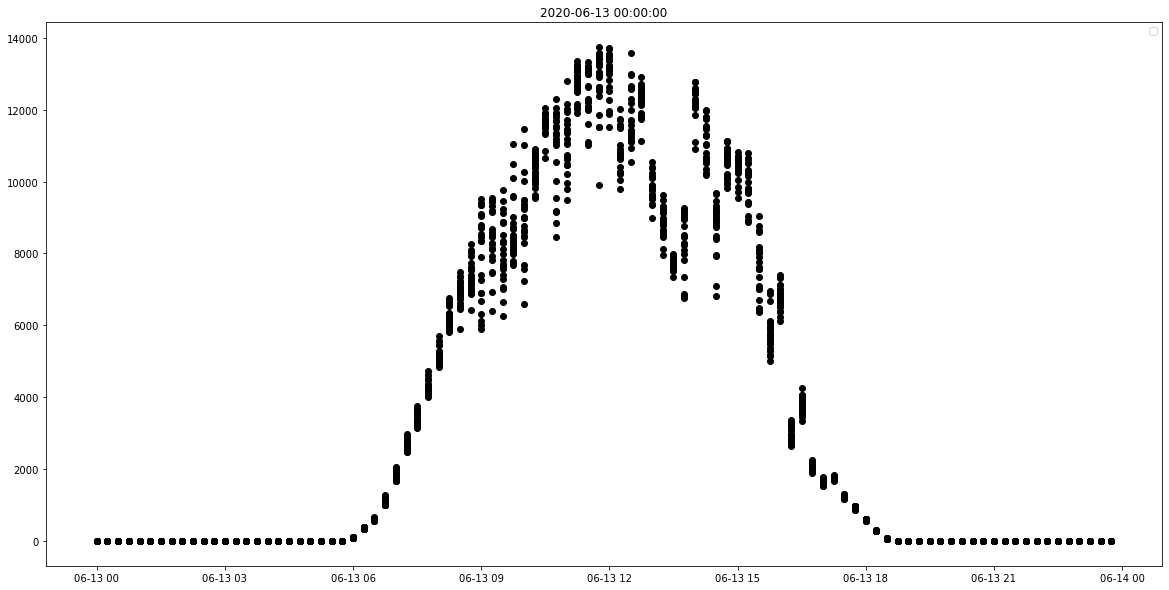

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.726863     0.993053
std          0.726863  1.000000     0.772329
IRRADIATION  0.993053  0.772329     1.000000
df['MeanDC'] std 3836.8187507120997
df['std'] std 962.9408396861529


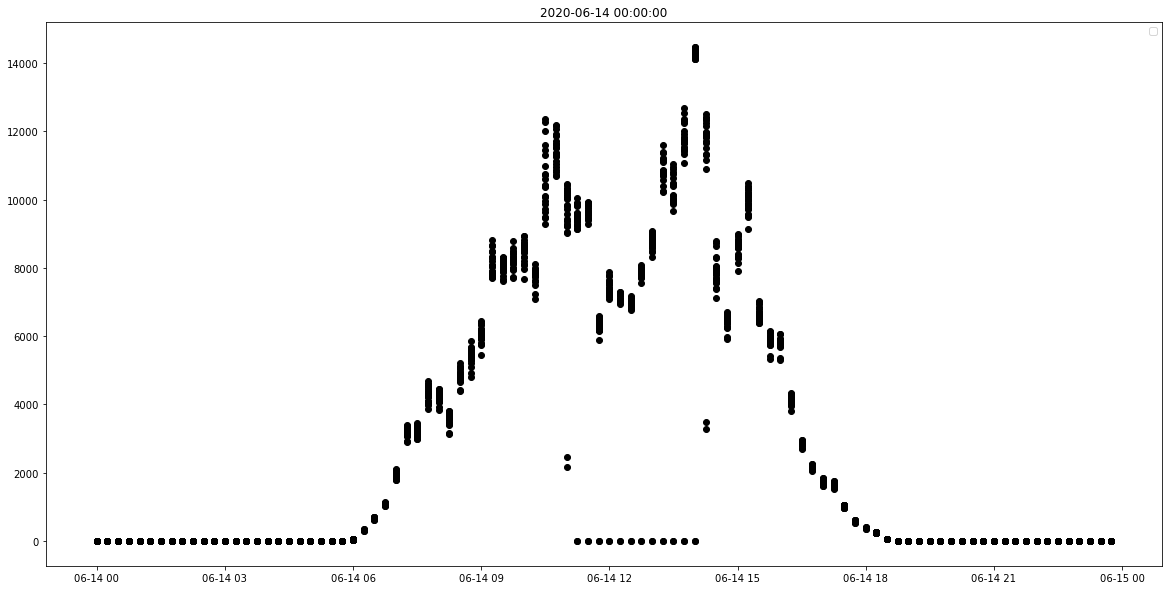

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.887305     0.997811
std          0.887305  1.000000     0.887433
IRRADIATION  0.997811  0.887433     1.000000
df['MeanDC'] std 3643.306679080751
df['std'] std 276.25503569956385


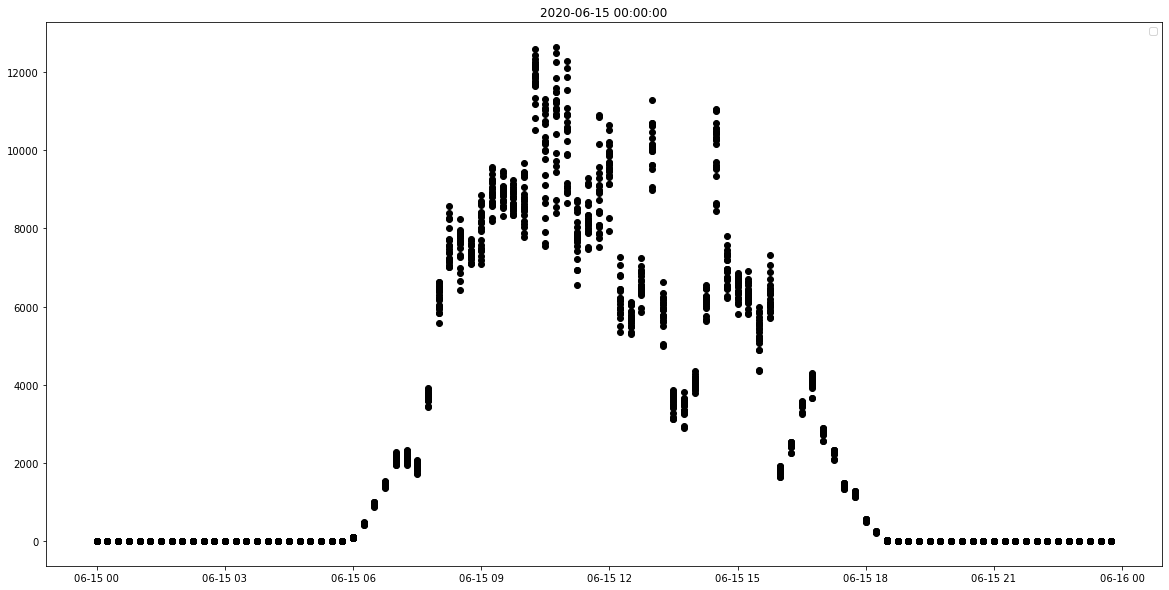

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.688985     0.998621
std          0.688985  1.000000     0.688211
IRRADIATION  0.998621  0.688211     1.000000
df['MeanDC'] std 3366.513752576832
df['std'] std 264.4471020501212


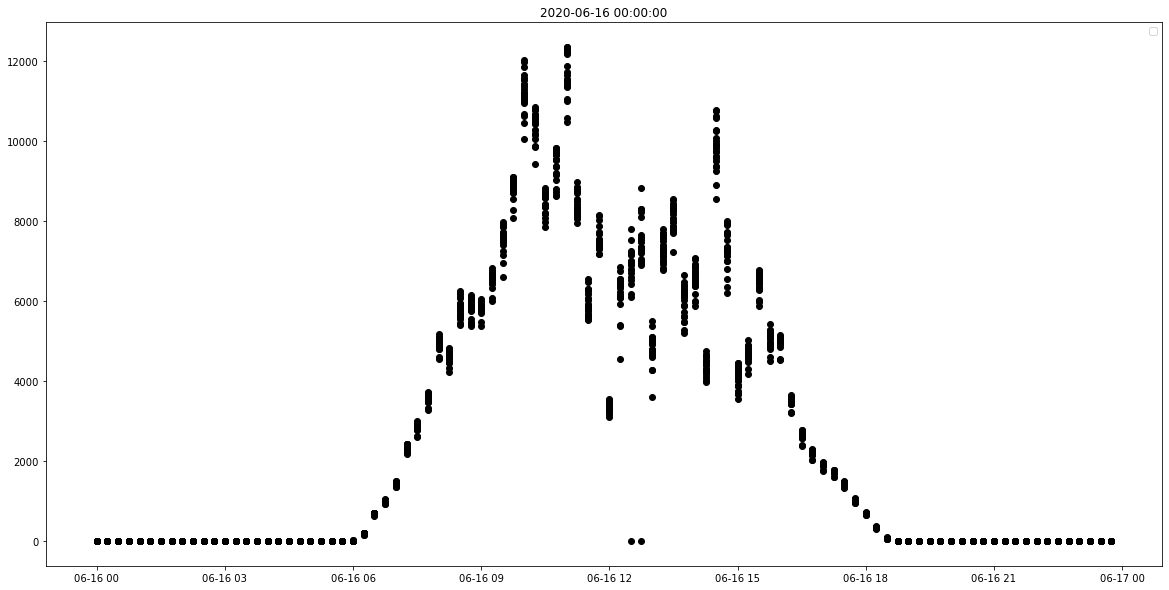

No handles with labels found to put in legend.


               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.873265     0.997754
std          0.873265  1.000000     0.872309
IRRADIATION  0.997754  0.872309     1.000000
df['MeanDC'] std 3525.6438590854677
df['std'] std 182.03872014120935


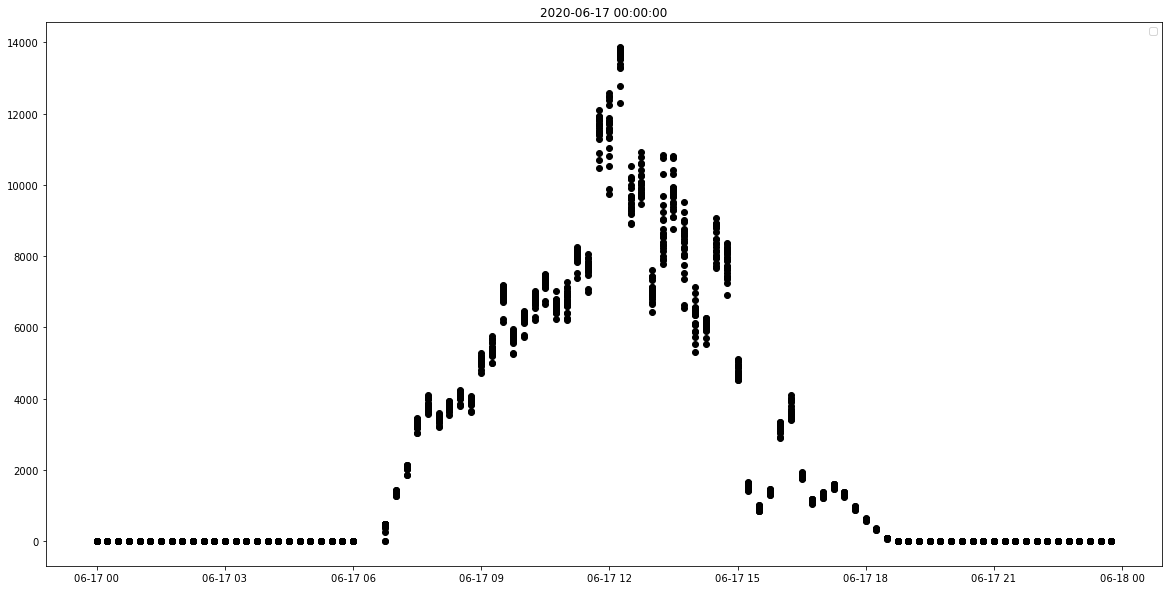

In [19]:
MeanDCstds = []
for dayofyear in merged_df.dt_y.dt.dayofyear.unique():
    d = datetime(2020, 1, 1) + timedelta(int(dayofyear) - 1)
    year = d.year
    month = d.month if d.month > 9 else '0' + str(d.month)
    day = d.day if d.day > 9 else '0' + str(d.day)
    temp = plot_dc_irr(f'{year}-{month}-{day} 00:00:00', f'{year}-{month}-{day} 23:59:00')
    MeanDCstds.append(temp)

In [194]:
MeanDCstds

[0.09588795898561427,
 0.04408312330171873,
 0.13636499841818986,
 0.10081462470445267,
 0.11579885840579891,
 0.04432930927356808,
 0.0776553714782707,
 0.06766263326030059,
 0.05107281893743815,
 0.08401954557740482,
 0.05369204481235112,
 0.10270396440730518,
 0.10513490876134746,
 0.06505270488312774,
 0.06959414301163314,
 0.04227137568925885,
 0.07685036178074951,
 0.06714502055874795,
 0.05185274530343304,
 0.04575504660172351,
 0.06884749440560896,
 0.07874976727678329,
 0.06938939094727398,
 0.13596244825727657,
 0.06294950929389806,
 0.0639511021440252,
 0.052957860394865185,
 0.03346684253651582,
 0.03135796121830729,
 0.06054933715862501,
 0.11749421875390018,
 0.060413830916537396,
 0.08218723416399935,
 0.08361261984518538]

In [168]:
def inv_rank(df, inv):
    temp = df[['SOURCE_KEY', 'DC_POWER']]
    temp.sort_values(by='DC_POWER', inplace=True)
    temp.reindex()
    keys = temp['SOURCE_KEY']
    dc_power = temp['DC_POWER']
    #print(keys)
    print(dc_power[0])
    r = 1
    max_t = dc_power[0]
    for i in range(len(keys)):
        if dc_power[i] > max_t:
            r+=1
        if inv == keys[i]:
            return r
        
def temp(row):
    row['pos'] = inv_rank(group, row['SOURCE_KEY'])
    return row
    
plant_gen['pos'] = 0
for _, group in plant_gen.groupby(plant_gen.index):
    m = pd.merge(plant_gen[plant_gen.index == _], group.apply(lambda row: temp(row), axis=1), how='left', on=['DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'dt'])
    print(m)
    #print(group.apply(lambda row: temp(row), axis=1))
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7206408.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7028673.0   
7    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6522172.0   
8    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7098099.0   
9    4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6271355.0   
10   4135001  bvBOhCH3iADSZry       0.0       0

KeyboardInterrupt: 

In [164]:
plant_gen[plant_gen['SOURCE_KEY'] == 'zBIq5rxdHJRwDNY']

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,dt,pos
DATE_TIME,,,,,,,,
2020-05-15 00:00:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0,2020-05-15 00:00:00,0
2020-05-15 00:15:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0,2020-05-15 00:15:00,0
2020-05-15 00:30:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0,2020-05-15 00:30:00,0
2020-05-15 00:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0,2020-05-15 00:45:00,0
2020-05-15 01:00:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0,2020-05-15 01:00:00,0
...,...,...,...,...,...,...,...,...
2020-06-17 22:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.0,6583369.0,2020-06-17 22:45:00,0
2020-06-17 23:00:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.0,6583369.0,2020-06-17 23:00:00,0
2020-06-17 23:15:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.0,6583369.0,2020-06-17 23:15:00,0
